# Causal Effect of Advertising on Conversion

**Mohammad (Mo) Khan**

**Causal Models in Data Science | Final Project**



## 1. Setup and Configuration

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')

## 2. Exploratory Data Analysis

### 2.1 Data Overview

In [2]:
# Load data
df = pd.read_csv('data/criteo-research-uplift-v2.1.csv.gz')
print(f"Dataset shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

Dataset shape: 13,979,592 rows, 16 columns


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.6164,10.0597,8.9764,4.6799,10.2805,4.1155,0.2944,4.8338,3.9554,13.1901,5.3004,-0.1687,1,0,0,0
1,12.6164,10.0597,9.0027,4.6799,10.2805,4.1155,0.2944,4.8338,3.9554,13.1901,5.3004,-0.1687,1,0,0,0
2,12.6164,10.0597,8.9648,4.6799,10.2805,4.1155,0.2944,4.8338,3.9554,13.1901,5.3004,-0.1687,1,0,0,0
3,12.6164,10.0597,9.0028,4.6799,10.2805,4.1155,0.2944,4.8338,3.9554,13.1901,5.3004,-0.1687,1,0,0,0
4,12.6164,10.0597,9.0380,4.6799,10.2805,4.1155,0.2944,4.8338,3.9554,13.1901,5.3004,-0.1687,1,0,0,0


In [3]:
# Data overview
print(f"Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
print(f"\nBasic stats:")
df.describe().round(4)

Shape: 13,979,592 rows, 16 columns

Missing values: 0

Data types:
float64    12
int64       4
Name: count, dtype: int64

Basic stats:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000,13979592.0000
mean,19.6203,10.0700,8.4466,4.1789,10.3388,4.0285,-4.1554,5.1018,3.9336,16.0276,5.3334,-0.1710,0.8500,0.0029,0.0470,0.0306
std,5.3775,0.1048,0.2993,1.3366,0.3433,0.4311,4.5779,1.2052,0.0567,7.0190,0.1682,0.0228,0.3571,0.0539,0.2116,0.1723
min,12.6164,10.0597,8.2144,-8.3984,10.2805,-9.0119,-31.4298,4.8338,3.6351,13.1901,5.3004,-1.3839,0.0000,0.0000,0.0000,0.0000
25%,12.6164,10.0597,8.2144,4.6799,10.2805,4.1155,-6.6993,4.8338,3.9108,13.1901,5.3004,-0.1687,1.0000,0.0000,0.0000,0.0000
50%,21.9234,10.0597,8.2144,4.6799,10.2805,4.1155,-2.4111,4.8338,3.9719,13.1901,5.3004,-0.1687,1.0000,0.0000,0.0000,0.0000
75%,24.4365,10.0597,8.7233,4.6799,10.2805,4.1155,0.2944,4.8338,3.9719,13.1901,5.3004,-0.1687,1.0000,0.0000,0.0000,0.0000
max,26.7453,16.3442,9.0520,4.6799,21.1235,4.1155,0.2944,11.9984,3.9719,75.2950,6.4739,-0.1687,1.0000,1.0000,1.0000,1.0000


### 2.2 Variable Descriptions

In [4]:
# Key variable distributions
print("=== Treatment/Exposure/Outcome ===\n")
for col in ['treatment', 'exposure', 'conversion', 'visit']:
    counts = df[col].value_counts().sort_index()
    pcts = df[col].value_counts(normalize=True).sort_index() * 100
    print(f"{col}:")
    print(f"  0: {counts[0]:,} ({pcts[0]:.2f}%)")
    print(f"  1: {counts[1]:,} ({pcts[1]:.2f}%)\n")

=== Treatment/Exposure/Outcome ===

treatment:
  0: 2,096,937 (15.00%)
  1: 11,882,655 (85.00%)

exposure:
  0: 13,551,380 (96.94%)
  1: 428,212 (3.06%)

conversion:
  0: 13,938,818 (99.71%)
  1: 40,774 (0.29%)

visit:
  0: 13,322,663 (95.30%)
  1: 656,929 (4.70%)



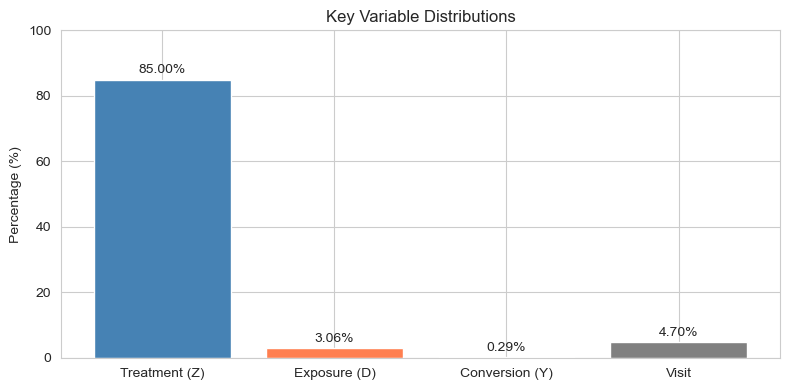

In [5]:
# Key variable distributions (computed from data)
fig, ax = plt.subplots(figsize=(8, 4))

variables = ['Treatment (Z)', 'Exposure (D)', 'Conversion (Y)', 'Visit']
pct_ones = [
    df['treatment'].mean() * 100,
    df['exposure'].mean() * 100,
    df['conversion'].mean() * 100,
    df['visit'].mean() * 100
]

bars = ax.bar(variables, pct_ones, color=['steelblue', 'coral', 'green', 'gray'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Key Variable Distributions')

# Add value labels
for bar, pct in zip(bars, pct_ones):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{pct:.2f}%', ha='center', va='bottom')

ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

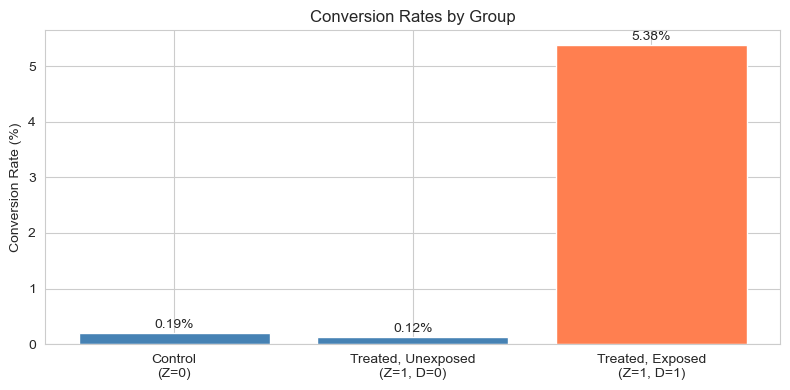

In [6]:
# Outcome rates by group
control = df[df['treatment'] == 0]
treated_unexposed = df[(df['treatment'] == 1) & (df['exposure'] == 0)]
treated_exposed = df[(df['treatment'] == 1) & (df['exposure'] == 1)]

groups = ['Control\n(Z=0)', 'Treated, Unexposed\n(Z=1, D=0)', 'Treated, Exposed\n(Z=1, D=1)']
conversion_rates = [
    control['conversion'].mean() * 100,
    treated_unexposed['conversion'].mean() * 100,
    treated_exposed['conversion'].mean() * 100
]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(groups, conversion_rates, color=['steelblue', 'steelblue', 'coral'])
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Conversion Rates by Group')

# Add value labels
for bar, rate in zip(bars, conversion_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
            f'{rate:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 2.3 Randomization Verification

In [7]:
# Covariate balance between treatment groups
covariates = [f'f{i}' for i in range(12)]

balance = pd.DataFrame({
    'Control Mean': df[df['treatment']==0][covariates].mean(),
    'Treated Mean': df[df['treatment']==1][covariates].mean(),
})
balance['Difference'] = balance['Treated Mean'] - balance['Control Mean']
balance['Std Diff'] = balance['Difference'] / df[covariates].std()

print("Covariate Balance (Treatment vs Control):\n")
print(balance.round(4))
print(f"\nMax |Std Diff|: {balance['Std Diff'].abs().max():.4f}")

Covariate Balance (Treatment vs Control):

     Control Mean  Treated Mean  Difference  Std Diff
f0        19.6517       19.6148     -0.0369   -0.0069
f1        10.0679       10.0703      0.0024    0.0229
f2         8.4482        8.4463     -0.0019   -0.0063
f3         4.2328        4.1694     -0.0634   -0.0474
f4        10.3365       10.3392      0.0027    0.0079
f5         4.0393        4.0266     -0.0127   -0.0295
f6        -3.9999       -4.1828     -0.1829   -0.0400
f7         5.0803        5.1056      0.0253    0.0210
f8         3.9347        3.9334     -0.0013   -0.0222
f9        15.8863       16.0526      0.1663    0.0237
f10        5.3319        5.3337      0.0018    0.0105
f11       -0.1709       -0.1710     -0.0001   -0.0051

Max |Std Diff|: 0.0474


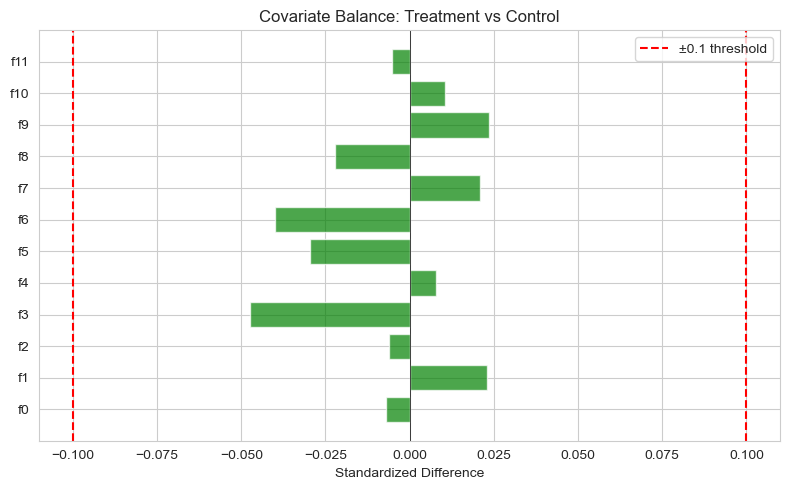

In [8]:
# Covariate balance plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['green' if abs(x) < 0.1 else 'red' for x in balance['Std Diff']]
ax.barh(balance.index, balance['Std Diff'], color=colors, alpha=0.7)
ax.axvline(x=0.1, color='red', linestyle='--', label='±0.1 threshold')
ax.axvline(x=-0.1, color='red', linestyle='--')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Standardized Difference')
ax.set_title('Covariate Balance: Treatment vs Control')
ax.legend()
plt.tight_layout()
plt.show()

### 2.4 Compliance Analysis

In [9]:
# Compliance analysis: Treatment (Z) vs Exposure (D)
print("=== Compliance Structure ===\n")
ct = pd.crosstab(df['treatment'], df['exposure'], margins=True)
ct.index = ['Z=0 (Control)', 'Z=1 (Treated)', 'Total']
ct.columns = ['D=0 (No Ad)', 'D=1 (Saw Ad)', 'Total']
print(ct)

print("\n=== Proportions ===")
ct_pct = pd.crosstab(df['treatment'], df['exposure'], normalize='index') * 100
ct_pct.index = ['Z=0 (Control)', 'Z=1 (Treated)']
ct_pct.columns = ['D=0 (No Ad)', 'D=1 (Saw Ad)']
print(ct_pct.round(2))

=== Compliance Structure ===

               D=0 (No Ad)  D=1 (Saw Ad)     Total
Z=0 (Control)      2096937             0   2096937
Z=1 (Treated)     11454443        428212  11882655
Total             13551380        428212  13979592

=== Proportions ===
               D=0 (No Ad)  D=1 (Saw Ad)
Z=0 (Control)     100.0000        0.0000
Z=1 (Treated)      96.4000        3.6000


In [10]:
# Compliance types
n_total = len(df)
n_treated = (df['treatment'] == 1).sum()
n_control = (df['treatment'] == 0).sum()

# In control: all D=0 (no always-takers)
always_takers = 0

# In treatment: D=1 are compliers
compliers_in_treated = (df['treatment'] == 1) & (df['exposure'] == 1)
complier_rate = compliers_in_treated.sum() / n_treated

# Never-takers: everyone else
never_taker_rate = 1 - complier_rate

print("=== Compliance Types ===")
print(f"Compliers: {complier_rate*100:.2f}% (see ad only when assigned)")
print(f"Never-takers: {never_taker_rate*100:.2f}% (never see ad)")
print(f"Always-takers: 0% (none in control saw ads)")
print(f"Defiers: 0% (assumed via monotonicity)")

=== Compliance Types ===
Compliers: 3.60% (see ad only when assigned)
Never-takers: 96.40% (never see ad)
Always-takers: 0% (none in control saw ads)
Defiers: 0% (assumed via monotonicity)


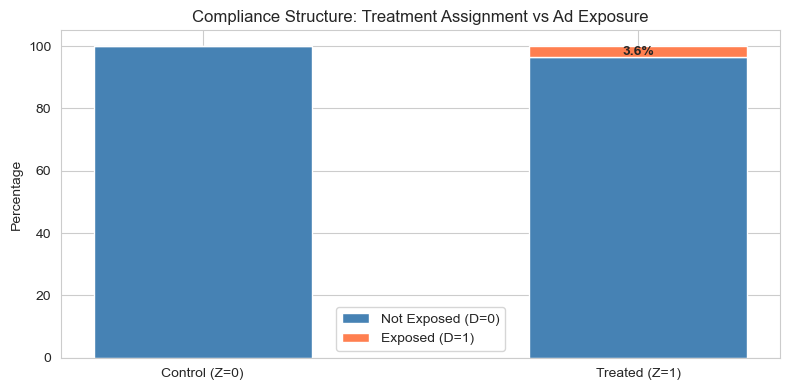

In [11]:
# Compliance structure
fig, ax = plt.subplots(figsize=(8, 4))

groups = ['Control (Z=0)', 'Treated (Z=1)']
not_exposed = [100, 96.4]
exposed = [0, 3.6]

x = np.arange(len(groups))
width = 0.5

bars1 = ax.bar(x, not_exposed, width, label='Not Exposed (D=0)', color='steelblue')
bars2 = ax.bar(x, exposed, width, bottom=not_exposed, label='Exposed (D=1)', color='coral')

ax.set_ylabel('Percentage')
ax.set_title('Compliance Structure: Treatment Assignment vs Ad Exposure')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()
ax.set_ylim(0, 105)

# Add percentage labels
for i, (ne, e) in enumerate(zip(not_exposed, exposed)):
    if e > 0:
        ax.text(i, ne + e/2, f'{e}%', ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Causal Identification & Estimation

### 3.1 Method 1: IV/2SLS

In [12]:
# Setup variables for IV estimation
Y = df['conversion'].values  # Outcome
D = df['exposure'].values     # Endogenous treatment
Z = df['treatment'].values    # Instrument
X = df[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']]

print(f"Sample size: {len(Y):,}")
print(f"Outcome (Y): conversion")
print(f"Treatment (D): exposure") 
print(f"Instrument (Z): treatment assignment")
print(f"Covariates (X): {list(X.columns)}")

Sample size: 13,979,592
Outcome (Y): conversion
Treatment (D): exposure
Instrument (Z): treatment assignment
Covariates (X): ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']


In [13]:
import statsmodels.api as sm

# First stage: D ~ Z + X
first_stage_X = sm.add_constant(pd.concat([pd.Series(Z, name='Z'), X.reset_index(drop=True)], axis=1))
first_stage = sm.OLS(D, first_stage_X).fit()

# Extract key results
z_coef = first_stage.params['Z']
z_se = first_stage.bse['Z']
z_tstat = first_stage.tvalues['Z']
f_stat = z_tstat ** 2  # F-stat for single instrument = t-stat squared

print("=== First Stage: D ~ Z + X ===")
print(f"Coefficient on Z: {z_coef:.4f}")
print(f"Standard Error: {z_se:.6f}")
print(f"t-statistic: {z_tstat:.2f}")
print(f"F-statistic: {f_stat:.2f}")
print(f"\nInstrument strength: {'Strong (F >> 10)' if f_stat > 10 else 'Weak'}")

=== First Stage: D ~ Z + X ===
Coefficient on Z: 0.0325
Standard Error: 0.000118
t-statistic: 276.44
F-statistic: 76419.14

Instrument strength: Strong (F >> 10)


In [14]:
from linearmodels.iv import IV2SLS

# Prepare data for IV2SLS
iv_data = pd.DataFrame({
    'Y': Y,
    'D': D,
    'const': 1
})
iv_data = pd.concat([iv_data, X.reset_index(drop=True)], axis=1)
iv_data['Z'] = Z

# IV2SLS: Y ~ 1 + X + [D ~ Z]
formula = 'Y ~ 1 + f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + [D ~ Z]'
iv_model = IV2SLS.from_formula(formula, data=iv_data).fit(cov_type='robust')

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.1299
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1299
No. Observations:            13979592   F-statistic:                 4.433e+04
Date:                Wed, Dec 10 2025   P-value (F-stat)                0.0000
Time:                        12:24:33   Distribution:                 chi2(13)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.2810     0.0081    -34.593     0.0000     -0.2969     -0.2651
f0          2.792e-05   4.26e-06     6.5532     0.00

In [15]:
# Extract LATE estimate
late = iv_model.params['D']
late_se = iv_model.std_errors['D']
late_ci = iv_model.conf_int().loc['D']
late_pval = iv_model.pvalues['D']

print("=== IV/2SLS Results: LATE ===")
print(f"LATE Estimate: {late:.6f}")
print(f"Standard Error: {late_se:.6f}")
print(f"95% CI: [{late_ci[0]:.6f}, {late_ci[1]:.6f}]")
print(f"p-value: {late_pval:.4e}")
print(f"\n=== Interpretation ===")
print(f"Ad exposure increases conversion probability by {late*100:.3f} percentage points for compliers.")

=== IV/2SLS Results: LATE ===
LATE Estimate: 0.028204
Standard Error: 0.000991
95% CI: [0.026262, 0.030145]
p-value: 0.0000e+00

=== Interpretation ===
Ad exposure increases conversion probability by 2.820 percentage points for compliers.


/var/folders/90/c9d062q17pj9mswrjp6r6ljr0000gp/T/ipykernel_42529/1691833283.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"95% CI: [{late_ci[0]:.6f}, {late_ci[1]:.6f}]")


### 3.2 Method 2: Double Machine Learning

In [16]:
# Install econml if needed
!pip install econml

from econml.iv.dml import DMLIV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

2025-12-10 12:24:44,266	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [17]:
# Prepare data for DML
Y = df['conversion'].values
D = df['exposure'].values
Z = df['treatment'].values.reshape(-1, 1)  # econml expects 2D for instrument
X = df[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

print(f"Y shape: {Y.shape}")
print(f"D shape: {D.shape}")
print(f"Z shape: {Z.shape}")
print(f"X shape: {X.shape}")

Y shape: (13979592,)
D shape: (13979592,)
Z shape: (13979592, 1)
X shape: (13979592, 12)


In [40]:
# Sample for faster iteration
np.random.seed(42)
sample_idx = np.random.choice(len(Y), size=500000, replace=False)
Y_sample = Y[sample_idx]
D_sample = D[sample_idx]
Z_sample = Z[sample_idx]
X_sample = X[sample_idx]

print(f"Sample size: {len(Y_sample):,}")

# Fit DML-IV with Random Forest (no inference)
dml_model = DMLIV(
    model_y_xw=RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    model_t_xw=RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    model_t_xwz=RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    cv=5
)

print("Fitting DML-IV model...")
dml_model.fit(Y_sample, D_sample, Z=Z_sample, X=X_sample)
print("Done!")

Sample size: 500,000
Fitting DML-IV model...
Done!


In [41]:
# Get individual effects
effects = dml_model.effect(X=X_sample)

# Point estimate (mean effect)
late = effects.mean()

# Manual SE: std / sqrt(n)
se = effects.std() / np.sqrt(len(effects))

# 95% CI
ci_lower = late - 1.96 * se
ci_upper = late + 1.96 * se

print(f"DML-IV LATE estimate: {late:.4f} ({late*100:.2f} pp)")
print(f"Standard Error: {se:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"95% CI: [{ci_lower*100:.2f} pp, {ci_upper*100:.2f} pp]")

DML-IV LATE estimate: 0.0299 (2.99 pp)
Standard Error: 0.0000
95% CI: [0.0298, 0.0300]
95% CI: [2.98 pp, 3.00 pp]


In [42]:
# Check effect distribution
print(f"Effect mean: {effects.mean():.4f}")
print(f"Effect std: {effects.std():.6f}")
print(f"Effect min: {effects.min():.4f}")
print(f"Effect max: {effects.max():.4f}")

Effect mean: 0.0299
Effect std: 0.031849
Effect min: -0.0409
Effect max: 0.2488


## 4. Results & Comparative Analysis

### 4.1 Summary of Estimates

In [ ]:
import matplotlib.pyplot as plt

# IV/2SLS - pull from model results
iv_estimate = iv_model.params['D']
iv_ci = iv_model.conf_int().loc['D']
iv_lower, iv_upper = iv_ci[0], iv_ci[1]

# DML-IV - already computed
dml_estimate = late
dml_lower = ci_lower
dml_upper = ci_upper

# Build results dict
results = {
    'IV/2SLS': {'estimate': iv_estimate, 'ci_lower': iv_lower, 'ci_upper': iv_upper},
    'DML-IV': {'estimate': dml_estimate, 'ci_lower': dml_lower, 'ci_upper': dml_upper}
}

# Print comparison table
print("=" * 60)
print(f"{'Method':<15} {'Estimate':>12} {'95% CI':>20}")
print("=" * 60)
for method, vals in results.items():
    ci_str = f"[{vals['ci_lower']*100:.2f}, {vals['ci_upper']*100:.2f}]"
    print(f"{method:<15} {vals['estimate']*100:>10.2f} pp {ci_str:>20}")
print("=" * 60)

Method              Estimate               95% CI
IV/2SLS               2.82 pp         [2.63, 3.01]
DML-IV                2.99 pp         [2.98, 3.00]


/var/folders/90/c9d062q17pj9mswrjp6r6ljr0000gp/T/ipykernel_42529/3653222507.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  iv_lower, iv_upper = iv_ci[0], iv_ci[1]


## 5. Evaluation & Sensitivity Analysis

### 5.1 Refutation Tests

In [27]:
!pip install dowhy

import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings('ignore')

print("DoWhy version:", dowhy.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 846.8 kB/s eta 0:00:00 0:00:01
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

Sample size: 500,000


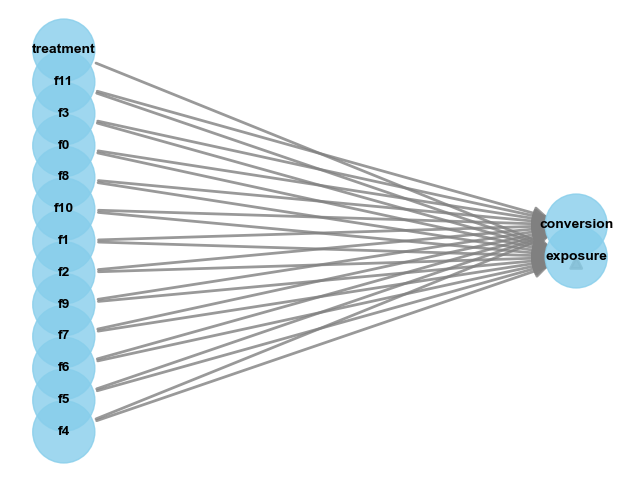

In [43]:
# Use a sample for faster computation
np.random.seed(42)
sample_size = 500000
sample_idx = np.random.choice(len(df), size=sample_size, replace=False)
df_sample = df.iloc[sample_idx].copy()

print(f"Sample size: {len(df_sample):,}")

# Define causal model
model = CausalModel(
    data=df_sample,
    treatment='exposure',
    outcome='conversion',
    instruments=['treatment'],
    common_causes=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
)

# View the causal graph
model.view_model()

In [44]:
# Identify the causal effect
estimand = model.identify_effect()
print(estimand)

# Estimate using IV
estimate = model.estimate_effect(
    estimand,
    method_name="iv.instrumental_variable"
)

print("\n=== IV Estimate ===")
print(f"LATE: {estimate.value:.4f} ({estimate.value*100:.2f} pp)")

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                          
───────────(E[conversion|f4,f5,f6,f7,f9,f2,f1,f10,f8,f0,f3,f11])
d[exposure]                                                     
Estimand assumption 1, Unconfoundedness: If U→{exposure} and U→conversion then P(conversion|exposure,f4,f5,f6,f7,f9,f2,f1,f10,f8,f0,f3,f11,U) = P(conversion|exposure,f4,f5,f6,f7,f9,f2,f1,f10,f8,f0,f3,f11)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                   -1⎤
 ⎢     d                   ⎛     d                  ⎞  ⎥
E⎢────────────(conversion)⋅⎜────────────([exposure])⎟  ⎥
 ⎣d[treatment]             ⎝d[treatment]            ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→conversion then ¬(U →→{treatment})
Estimand assumption 2, Exclusion: If we remove {treatment}→{exposure}, then ¬({treatment}→conversion)

### Estimand : 3
Estimand

In [45]:
# Test 1: Placebo Treatment (replace treatment with random)
print("Running Placebo Treatment Test...")
placebo_test = model.refute_estimate(
    estimand, estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print(placebo_test)

# Test 2: Data Subset (use 80% of data)
print("\nRunning Data Subset Test...")
subset_test = model.refute_estimate(
    estimand, estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8
)
print(subset_test)

# Test 3: Random Common Cause (add simulated confounder)
print("\nRunning Random Common Cause Test...")
random_cause_test = model.refute_estimate(
    estimand, estimate,
    method_name="random_common_cause"
)
print(random_cause_test)

Running Placebo Treatment Test...
Refute: Use a Placebo Treatment
Estimated effect:0.034684226528157946
New effect:nan
p value:0.0


Running Data Subset Test...
Refute: Use a subset of data
Estimated effect:0.034684226528157946
New effect:0.034458495894161625
p value:0.92


Running Random Common Cause Test...
Refute: Add a random common cause
Estimated effect:0.034684226528157946
New effect:0.034684226528157946
p value:1.0

